# RATINGS: scRaping and AnalyzIng biTcoIN mininG poolS 
- Alunno: Donaldo Buzi
- Matricola: 635116
- Anno: 2023/2024, secondo appello

In [1]:
import sys
print(sys.version)

3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]


## Librerie
Di seguito importo tutte le librerire necessarie per il progetto. Riporto anche le versioni usate in questo progetto:

- requests==2.32.2
- numpy==1.26.4
- matplotlib==3.8.4
- pandas==2.1.4
- networkx==3.1
- beautifulsoup4==4.12.2
- fake-useragent==1.4.0
- pydot==2.0.0

In [1]:
import re
import time
import random
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import pandas as pd
import networkx as nx
from bs4 import BeautifulSoup

from fake_useragent import UserAgent
from networkx.drawing.nx_pydot import graphviz_layout

## Caricare i csv
In questa sezione carico tutti i csv necessari per il progetto. Ogni sezione non andrà mai a modificare i dataset originali.
Successivamente converto alcuni tipi per risparmiare un po' di memoria dove possibile.
Ho specificato anche i tipi per ottimizzare il consumo di memoria, ripsettivamente la memoria per ogni dataset passa da:

- 489Mb a 250Mb (inputs)
- 295Mb a 213.5Mb (mapping)
- 938.9Mb a 446Mb (outputs)
- 403.3Mb a 252.1Mb (transactions)

Quindi ho ottenuto una riduzione complessiva quasi del 50%.

In [3]:
inputs = pd.read_csv("webScraping2024Project/inputs.csv", names = ["txId","prevTxId","prevTxPos"], dtype={"txId": "int32", "prevTxId": "int32", "prevTxPos": "int32"})
mapping = pd.read_csv("webScraping2024Project/mapAddr2Ids8708820.csv",names=["address","addressId"], dtype ={"addressId" : "int32"})
outputs = pd.read_csv("webScraping2024Project/outputs.csv", names=["txId", "position", "addressId", "amount","scriptType"], dtype = {"txId" : "int32", "position":"int16", "addressId":"int32","scriptType":"int8"})
transactions = pd.read_csv("webScraping2024Project/transactions.csv",names=["timestamp", "blockId","txId","isCoinBase","fee"], dtype = {"txId" : "int32", "blockId" : "int32", "isCoinBase": "int8"})
transactions["timestamp"]=pd.to_datetime(transactions["timestamp"], unit="s")

# Analisi del Dataset
### Studio l'andamento delle fee contenute nelle transazioni rispetto la congestione della blockchain. 
Vengono ignorate le transazioni coinbase come specificato nel testo. La formula usata per calcolare la dimensione della transazione è quella riportata nel testo: <code>size(transaction)= size(input)* n_inputs+ size (output)* n_outputs + size (script)</code>.

La prima operazione è filtrare le transazioni con le sole che non sono "coinbase". Successivamente filtro gli input e output per mantenere solo le entries che compaiono nelle transizioni filtrate precedentemente. 
Infine mappo le dimensioni degli scripttype e creo due series in cui conto quante volte un txId compare nei dataframe di input e output.

In [4]:
transactions_no_coinbase = transactions[transactions.isCoinBase == 0]
inputs_no_coinbase = inputs[inputs.txId.isin(transactions_no_coinbase.txId)]
outputs_no_coinbase = outputs[outputs.txId.isin(transactions_no_coinbase.txId)]
script_type_weight = {0: 0, 1: 153, 2: 180, 3: 291}
outputs_no_coinbase.loc[:,"scriptType"]= outputs_no_coinbase.loc[:,"scriptType"].map(script_type_weight)
inputs_vc = inputs_no_coinbase.txId.value_counts(sort=False)
outputs_vc = outputs_no_coinbase.txId.value_counts(sort=False)

In questa cella definisco tutto il necessario per calcolarmi l'effettiva dimensione. 
Moltiplico le due series per uno scalare, i valori usati sono quelli riportati nel testo del progetto.
Infine, faccio una groupby su <code>txId</code> a cui applico una funzione sum su <code>scriptType</code>, in modo da sommare i vari script utilizzati dai diversi output in una transazione. 

In [5]:
input_mean_size = 40
output_mean_size = 9
group_by_freq_key = "d"
inputs_size = inputs_vc * input_mean_size
outputs_size = outputs_vc * output_mean_size
size_df = outputs_no_coinbase.groupby("txId").agg({"scriptType":"sum"}).scriptType

Calcolo ora la <code>total_size</code>, svolgendo una somma delle tre series.
Creo un dataframe <code>res</code> con i dati della serie risultante dalla somma del passo precedente. Le colonne sono date dai valori di  <code>txId</code>, quindi conterrà il valore degli indici della serie e dalla colonna <code>transaction_size</code>, che conterrà gli effettivi valori della serie.
Svolgo un inner join tra <code>res</code> e il dataframe <code>transactions_no_coinbase</code> su <code>txId</code>, dopodiché faccio una groupby, usando la funzione Grouper, in quanto voglio svolgere un raggruppamento sulle date, la frequenza di raggruppamento scelta, è quella giornaliera.

Svolgo infine sul raggruppamento anche una funzione di somma sulle colonne <code>fee</code> e <code>transaction_size</code> in modo da avere la somma dei valori per ogni intervallo di tempo. Per semplificare, se ho due intervalli t1 e t2, e ponendo di usare la colonna <code>fee</code>, con i seguenti valori [1,2,3] e [2,3,4], ottengo per t1: 6  e per t2: 9.

Al termine dell'esecuzione di questa cella, sarà disponibile un dataframe <code>to_plot</code> da poter utilizzare per plottare i nostri dati.

In [6]:
total_size = inputs_size + outputs_size + size_df
res = pd.DataFrame({'txId':total_size.index, 'transaction_size':total_size.values})
merged = pd.merge(transactions_no_coinbase, res, how="inner", on="txId")
to_plot = merged.groupby(pd.Grouper(key="timestamp",freq=group_by_freq_key)).agg({"fee":"sum","transaction_size":"sum"})

Utilizzo la libreria matplotlib per fare creare un plot dei dati, è possibile notare una correlazione tra la congestione e il valore totale delle fee. Questa correlazione diventa più forte dopo il 2011-07 circa.

L'asse y è scalato con una funzione di log per rendere il risultato più facilmente analizzabile, su di esso sono rappresentati i valori di <code>fee</code> e <code>transaction_size</code>. Sull'asse x vengono invece riportati gli intervalli temporali


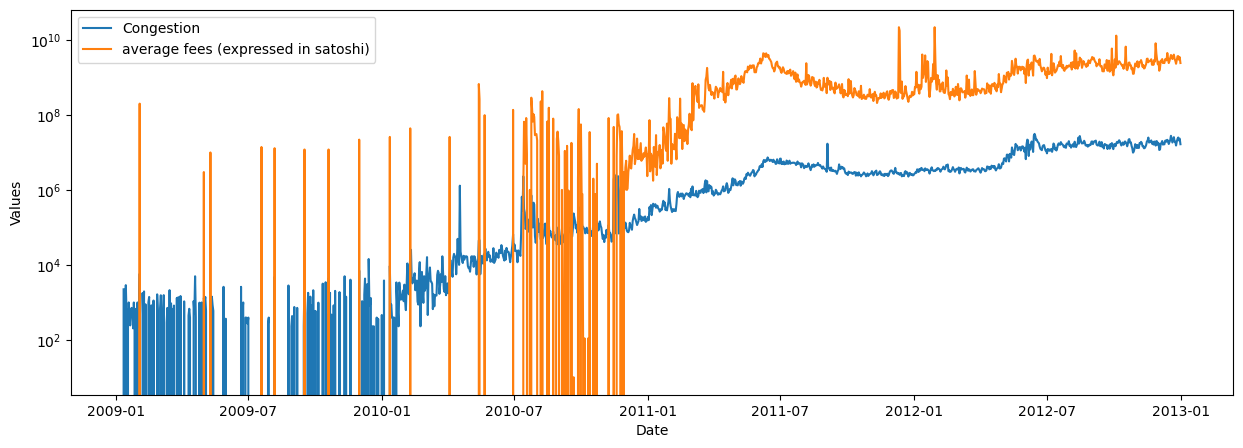

In [7]:
plt.figure(figsize=(15,5))
plt.plot(to_plot.index, to_plot["transaction_size"], label = "Congestion")
plt.plot(to_plot.index, to_plot["fee"], label ="average fees (expressed in satoshi)")
plt.xlabel("Date")
plt.ylabel("Values")
# we do it in "log" because otherwise the chart won't show any useful pattern
plt.yscale("log")
plt.legend()
plt.show()

# Analizziamo ora i tipi di script contenuti nel dataset
Questa volta mappo gli scriptType con il loro nome effettivo. 
Creo successivamente una pivot table in modo da avere un dataframe indicizzato dal txId, in cui le colonne sono date dai valori possibli di scriptType. Le colonne generate contengono il numero di volte che uno certo script è stato usato in un output in un determinato txId.

Questo dataframe è utile perché mi permette di fare un inner join con il dataframe transactions, ottenendo in maniera molto semplice un dataframe che mi permette di raggruppare sul "timestamp" e di contare il numero di volte che uno script è stato usato in un certo intervallo temporale (il ragionamento è analogo al precedente, ovvero quando stavo parlando di prepare i dati per il plot della correlazione tra congestion e fee). 

In [8]:
script_type_names = {0: "Unknown", 1: "P2PK", 2: "P2KH", 3: "P2SH"}
outputs.loc[:,"scriptType"] = outputs.loc[:,"scriptType"].map(script_type_names)
pivot_outputs = outputs.pivot_table(index="txId", columns="scriptType", aggfunc='size', fill_value=0)
merged = pd.merge(pivot_outputs,transactions, on="txId")
grouped = merged.groupby(pd.Grouper(key="timestamp",freq="W")).agg("sum")
grouped = grouped[["P2KH","P2PK","P2SH","Unknown"]]

Il dataframe generato al passo precedente mi permette ora di plottare con facilità i vari grafici per ogni script, l'intervallo temporale di raggruppamento usato è quello settimanale. 
Sull'asse x sono riportate le date e sull'asse y i valori, sempre scalati con una funzione log per rendere il tutto più confrontabile.
Si può notare che il più usato negli ultimi periodi (al giorno d'oggi potrebbe essere ulteriormente cambiato, il dataset si ferma al 2013) è il P2KH

              P2KH  P2PK  P2SH  Unknown
timestamp                              
2009-01-04       0     1     0        0
2009-01-11       0   168     0        0
2009-01-18       1   825     0        0
2009-01-25       3   904     0        0
2009-02-01       4   795     0        0
...            ...   ...   ...      ...
2012-12-09  514420  5459     4      106
2012-12-16  616136  5449     2       81
2012-12-23  696674  4749     4      142
2012-12-30  649610  5643     1      136
2013-01-06   73860   726     0       21

[210 rows x 4 columns]


<Figure size 640x480 with 0 Axes>

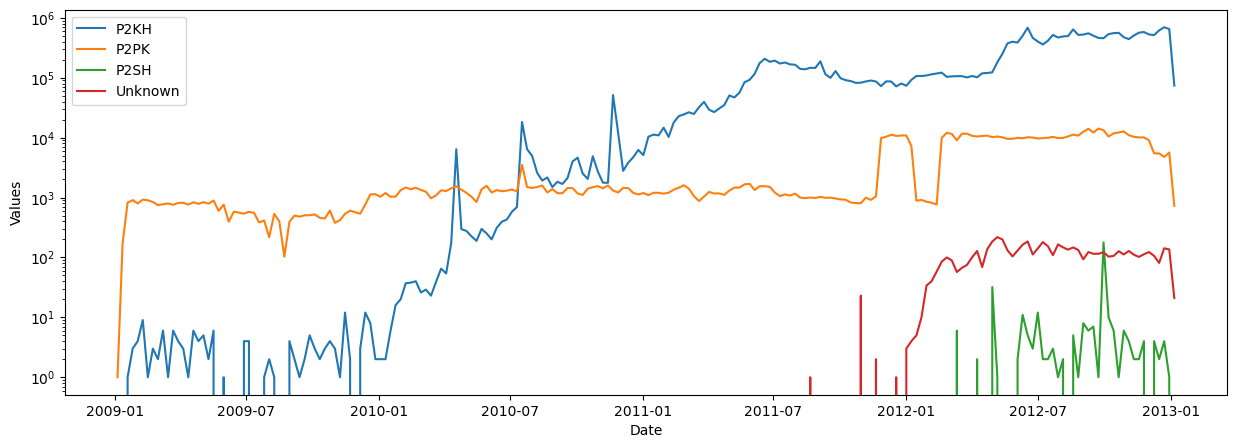

In [9]:
plt.clf()
plt.figure(figsize=(15,5))
print(grouped)
for key in grouped.columns:
    plt.plot(grouped.index, grouped[key], label = key)
plt.xlabel("Date")
plt.ylabel("Values")
plt.yscale("log")
plt.legend()
plt.show()

## Scraping
Definisco alcuni variabili e metodi che mi saranno utili successivamente.

In [10]:
base_url="https://www.walletexplorer.com/"
path = "wallet/"
pool_name_list=["DeepBit",
            "Eligius",
            "BTCGuild",
            "BitMinter"]

I metodi:
- <code>generate_proxies</code> viene usato per generare una lista di proxy da poter usare, in modo da evitare di essere bloccati da WalletExplorer per aver effettuato troppe richieste in poco tempo. Il metodo prende spunto da quello visto a lezione. Nello specifico fa scraping di "www.sslproxies.org da cui ci generiamo una lista di (ip,porta)
- <code>request_with_proxy</code> viene usato per eseguire una richiesta sfruttando una proxy e aggiungendo un user agent in modo ridurre ulteriormente le proabilità di essere bannato. Anche per questo metodo ho preso spunto da un metodo visto a lezione. Le sleep da 5 secondi servono per attendere una piccola quantità di tempo prima di riprovare a svolgere la richiesta con una proxy differente. Se ho terminato le proxies allora genero un eccezione, in modo da far capire ad un possibile utilizzatore che le richieste falliscono per mancanza di proxy disponibili.

In [12]:
proxies = [] # Lista che conterrà i proxy come dizionari con chiavi ip e porta
# Funzione per la estrazione dei proxy da sslproxies.org
def generate_proxies():
    proxies.clear()
    proxies_req = requests.get('https://www.sslproxies.org/')
    b_soup = BeautifulSoup(proxies_req.text, 'html.parser')
    proxies_table = b_soup.find('table', class_='table table-striped table-bordered')
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append({
        'ip':   td[0].string,
        'port': td[1].string})
agent = UserAgent()
def request_with_proxy(url):
    while True:
        if len(proxies)==0:
            raise Exception("No more proxies available. Try regenerating them using generate_proxies().")
        proxy = random.choice(proxies)
        user_agent = agent.random
        headers = {"User-Agent": user_agent}
        try:
            response = requests.get(url,proxies=proxy, headers=headers)
            if response.text.startswith("Too many requests."):
                 proxies.remove(proxy)
                 time.sleep(5)
                 continue
            return response
        except:
            proxies.remove(proxy)
            time.sleep(5)
            continue

- <code>get_pool_address</code> viene usato per ottenere l'url "canonico" associato al nome del pool. Essenzialmente svolgo una ricerca nel sito passando come valore il nome di un pool.
- <code>get_addresses</code> serve per ottenere gli indirizzi contenuti ad una certa pagina del pool. Il metodo restituisce una lista di stringhe dove andiamo a cercare tutti gli a[href] che contengono un url che inizia con "/address", una volta ottenuti, prendiamo da questi il valore della stringa contenuta nel tag "a".
- <code>get_pool_addresses</code> si occupa di popolare il dictionary passato come parametro, per ogni pool crea una entry, ogni entry avrà come valore una lista di indirizzi. La lista è generata concatenando ad ogni iterazione il risultato accumulato con il nuovo risultato restituitomi da <code>get_addresses</code>. Questo metodo si ferma solo quando il numero di indirizzi restituiti da <code>get_addresses</code> è uguale a 0, ovvero non ci sono più indrizzi perché siamo arrivati all'ultima pagina. Le pagine vengono incrementate ad ogni iterazione del costrutto while.

In [13]:
def get_pool_address(base_url, query):
    response = request_with_proxy(base_url+f"?q={query}")
    if response == None or not response.history:
        return
    pool_url = response.url + "/addresses"
    return pool_url

def get_addresses(url,page_number):
    response = request_with_proxy(url+f"?page={page_number}")
    b_soup=BeautifulSoup(response.text,"html.parser")
    if b_soup.table == None: #it means we have done too many requests
        return []
    return [address.string for address in b_soup.table.find_all("a", {"href": re.compile(r"^/address")})]

def get_pool_addresses(pool_url,pool_name, pool_addresses):
    start = 1
    shouldStop = False
    pool_addresses[pool_name] =  list()
    while not shouldStop:
        addresses = get_addresses(pool_url, start)
        start += 1
        if len(addresses) == 0:
            shouldStop = True
        pool_addresses[pool_name] = pool_addresses[pool_name] + addresses

A questo punto è tutto pronto per utilizzare i metodi precedentemente dichiarati.
Inizio chiamando <code>generate_proxies</code>, in modo da generare le proxy che andremo a utilizzare. 

Svolgo un <code>for</code> sulla lista che contiene i nomi dei pool, in modo da generare gli url necessari per ogni pool. Se il metodo restituisce l'url correttamente, allora chiamo <code>get_pool_addresses</code> per reperire gli indirizzi associati a quel pool. Una volta recuperati gli indirizzi di quel pool, passo al prossimo pool.

Infine, svolgo un ultimo for in cui genero per ogni pool una lista data dalla coppia (nome_pool, indirizzi), questa lista viene successivamente usata per generare un dataframe in cui ad ogni indirizzo è associato il pool a cui appartiene.

Per comodita stampo anche il numero di indirizzi trovati per ogni pool, in questo modo è possibile capire se manca qualche indirizzo controllando su WalletExplorer. 

In [14]:
pool_addresses={}
generate_proxies()
for pool_name in pool_name_list:
    pool_url = get_pool_address(base_url, pool_name)
    print(pool_url)
    if pool_url == None:
        continue
    get_pool_addresses(pool_url, pool_name, pool_addresses)
res = []
for key in pool_addresses:
    res +=[(key,i) for i in pool_addresses[key]]
    print(key, len(pool_addresses[key]))
pool_df = pd.DataFrame(res, columns =["pool","address"])

https://www.walletexplorer.com/wallet/DeepBit.net/addresses
https://www.walletexplorer.com/wallet/Eligius.st/addresses
https://www.walletexplorer.com/wallet/BTCGuild.com/addresses
https://www.walletexplorer.com/wallet/BitMinter.com/addresses
DeepBit 2
Eligius 1032
BTCGuild 7865
BitMinter 440


L'obiettivo delle seguenti due celle è quello di generare un dataframe che ci servirà per organizzare i dati da plottare.
Ogni entry di questo dataframe (<code>output_mapped</code>) contiene il nome del pool a cui apparitene la entry, se non appartiene a nessuno dei quattro pool allora il suo valore è NaN.
Iniziamo svolgendo il merge tra <code>mapping</code> e <code>outputs</code> su <code>addressId</code> per ricostruire il valore associato ad ogni <code>addressId</code>, ovvero inseriamo una colonna contenente l'hash degli indirizzi (chiamato <code>address</code> nel dataframe <code>mapping</code> per semplicità). 

Successivamente svolgo il merge tra il risulato del primo merge e il dataframe ottenuto nelle celle precedenti (<code>pool_df</code>) sulla colonna <code>address</code>. Tutto questo è necessario per avere in ogni entry il pool a cui esso appartiene. 

All'ultimo passo svolgo il merge tra il risultato del passo precedente e il dataframe delle transazioni ma filtrate per contenere solo quelle in cui il valore di "isCoinBase" è uguale a 1, ovvero le transazioni che sono "transizioni coinbase".

Il dataframe risultante viene mostrato al termine dell'esecuzione della seconda cella.

In [15]:
output_mapped = pd.merge(mapping,outputs, how="inner", on="addressId")
output_mapped = pd.merge(output_mapped,pool_df, how="left", on="address")

In [16]:
only_coinbase = pd.merge(output_mapped, transactions[transactions.isCoinBase == 1], on="txId")
only_coinbase

,address,addressId,txId,position,amount,scriptType,pool,timestamp,blockId,isCoinBase,fee
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa,0,0,0,5000000000,P2PK,NaN,2009-01-03 18:15:05,0,1,0
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX,1,1,0,5000000000,P2PK,NaN,2009-01-09 02:54:25,1,1,0
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1,2,2,0,5000000000,P2PK,NaN,2009-01-09 02:55:44,2,1,0
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR,3,3,0,5000000000,P2PK,NaN,2009-01-09 03:02:53,3,1,0
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG,4,4,0,5000000000,P2PK,NaN,2009-01-09 03:16:28,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
508799,12uTvB3SRh4p6ytc45xxVYe6S12rCBf1E6,8707816,10570768,0,2501990000,P2PK,NaN,2012-12-31 22:08:55,214547,1,0
508800,#5893,8708320,10571695,0,2500020000,Unknown,NaN,2012-12-31 23:09:32,214556,1,0
508801,1JkTWpeJUwu9Mbhpk2EyF8Kh2J77bFab1p,8708330,10571704,0,2502825000,P2PK,NaN,2012-12-31 23:07:36,214557,1,0
508802,1FeKwcQ4o5Eh7nsRDdG6jx8ysGzgBSij4S,8708362,10571747,0,2536100000,P2PK,NaN,2012-12-31 23:21:12,214558,1,0


Nelle seguenti celle inizio ad adattare il dataframe generato al passo precedente per ottenere un plot dei dati come da richiesta.

Dal dataframe filtro le entries che hanno come valore nella colonna <code>pool</code> NaN e le raggruppo per <code>address</code>. Per ogni gruppo mi calcolo la funzione <code>size()</code>, che mi permette essenzialmente di contare quante volte compare un determinato indirizzo. Infine ordino per valori di size decrescenti.

Dal dataframe generato, prendo le prime 4 entry, che rappresentano i 4 miner principali. Vado successivamente a deanonimizzare i 4 miner, svolgendo una ricerca su WalletExplorer in cui passo l'hash del miner. Creo cosi un dictionary in cui le chiavi sono gli hash del miner e le coppie (dimensione_coinbase, indirizzo) sono i valori.

Facciamo nuovamente scraping di WalletExplorer, prendiamo il valore del titolo della pagina e lo splittiamo per prendere l'indirizzo del miner.

In [17]:
nd_coinbase_outputs=only_coinbase[only_coinbase["pool"].isnull()].groupby(["address"],as_index=False).size().sort_values(["size"],ascending=False)
addresses = nd_coinbase_outputs.set_index("address")[0:4]["size"].to_dict()
miners={}
for address in addresses:
    s_coinbase = addresses[address]
    req = request_with_proxy(base_url+f"?q={address}")
    if req == None:
        raise Exception("You've probably been banned")
    if not req.history:
        break
    b_soup=BeautifulSoup(req.text,"html.parser")
    # Example 3e486bf1d3615fb8 [WalletExplorer.com]
    miner=b_soup.title.string.split(" ")[0]
    if miner in miners:
        miners[miner][0]+= s_coinbase
        miners[miner][1].append(address)
    else:
        miners[miner]=(s_coinbase,[address])
    time.sleep(1) # wait a little bit everytime to avoid being banned

Aggiungiamo i miner deanonimizzati nella colonna <code>pool</code> con l'indirizzo del miner. A tutte le entry rimaneneti senza un valore <code>pool</code>, ovvero con valore NaN, assegniamo la sigla "Others".

In [18]:
for key in miners:
    print(key, miners[key])
    only_coinbase.loc[only_coinbase["address"] == miners[key][1][0], "pool"] = key

only_coinbase.loc[only_coinbase["pool"].isnull(),"pool"] = "Others"

3e486bf1d3615fb8 (2587, ['1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm'])
EclipseMC.com-old (1919, ['1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9'])
019a46b8d84bf5b5 (1741, ['1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy'])
01a990df756979ef (1738, ['151z2eoe2D9f6cohGNNU96GsKAqLfYP8mN'])


# Analisi numero blocchi minati
## Analisi globale
Anlizzo ora il numero di blocchi minati dai pool e dai miner.
Costruisco un dataframe con due colonne: <code>pool</code> e <code>size</code>, sfruttando la funzione <code>value_counts</code> che mi permette di contare il numero di volte che compare un pool/miner per ogni transazione, da cui escludo il valore di "Others".
Infine genero un plot, in cui, nell'asse x viene riportato il pool/miner e nell'asse y il numero di blocchi minati.

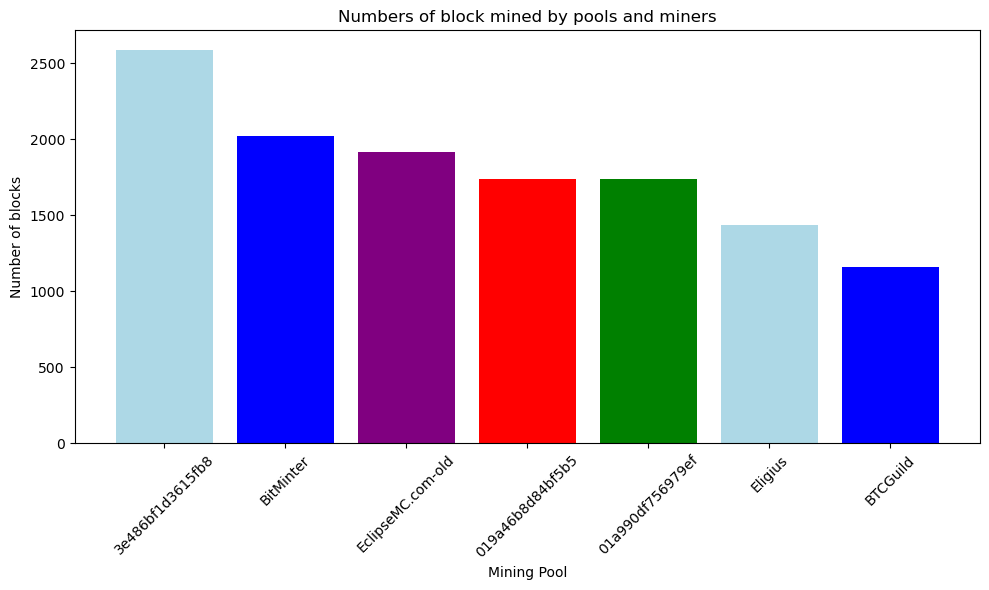

In [25]:
# Build dataframe from our data
vc = only_coinbase["pool"].value_counts()
data = pd.DataFrame(list((x,vc[x]) for x in vc.index[1:]), columns = ["pool","size"])
color = ['lightblue', 'blue', 'purple', 'red', 'green']
plt.figure(figsize=(10, 6))
plt.bar(data["pool"],data["size"],color = color)
plt.title("Numbers of block mined by pools and miners")
plt.xlabel("Mining Pool")
plt.ylabel("Number of blocks")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analisi andamento temporale
Per plottare i dati con un andamento temporale devo adattare nuovamente i dati. Per questo motivo genero un nuovo dataframe usando <code>pivot_table</code>. L'indice è dato dal grouper sul timestamp della transazione con una frequenza di 2 mesi (quindi sono gli intervalli temporali), le colonne sono date dai valori di <code>pool</code>. I valori vengono presi dalla colonna <code>blockId</code>, infine applico la funzione count che mi permette di contare i blocchi associati ad ogni pool.

In sintesi, sto generando un dataframe in cui le colonne sono i valori della colonna originale <code>pool</code> e in cui ogni colonna (quindi per ogni pool/miner) contiene il numero di blocchi minati nell'intervallo selezionato.

Ovvero, il dataset ha una forma del genere:

        miner1    miner2

    t1    5        10

    t2    3        45


Il tipo di grafico utilizzato è il bar, sia in versione stacked che non.

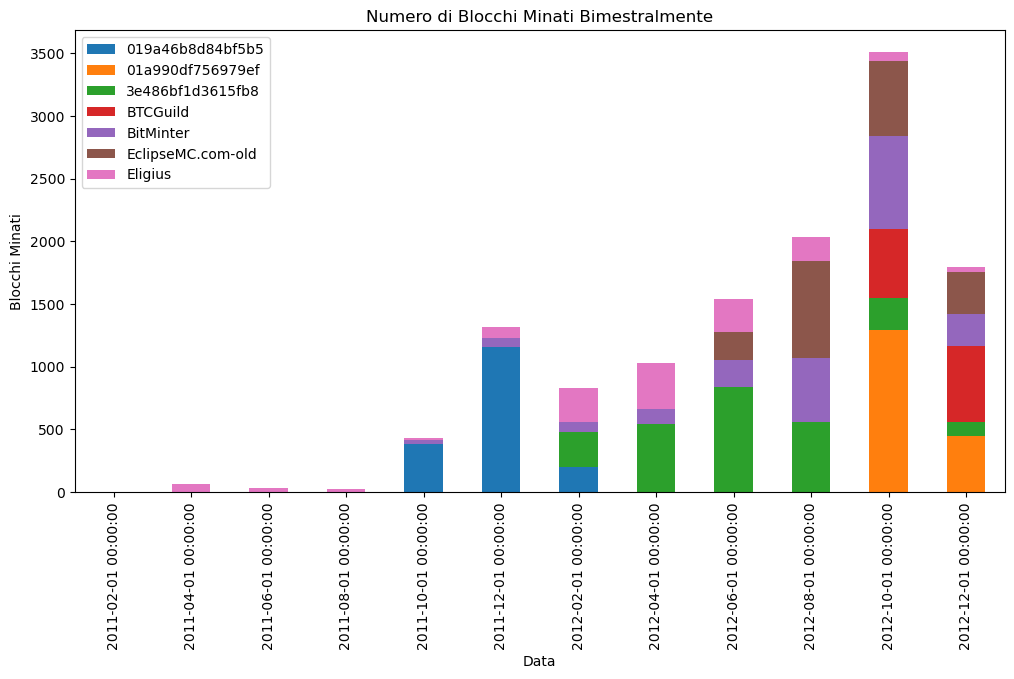

In [20]:
framed = only_coinbase[only_coinbase["pool"]!="Others"].pivot_table(index=pd.Grouper(key="timestamp", freq="2MS"), columns="pool", values="blockId", aggfunc="count", fill_value=0)

ax = framed.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Numero di Blocchi Minati Bimestralmente")
plt.xlabel("Data")
plt.ylabel("Blocchi Minati")

plt.legend()
plt.show()

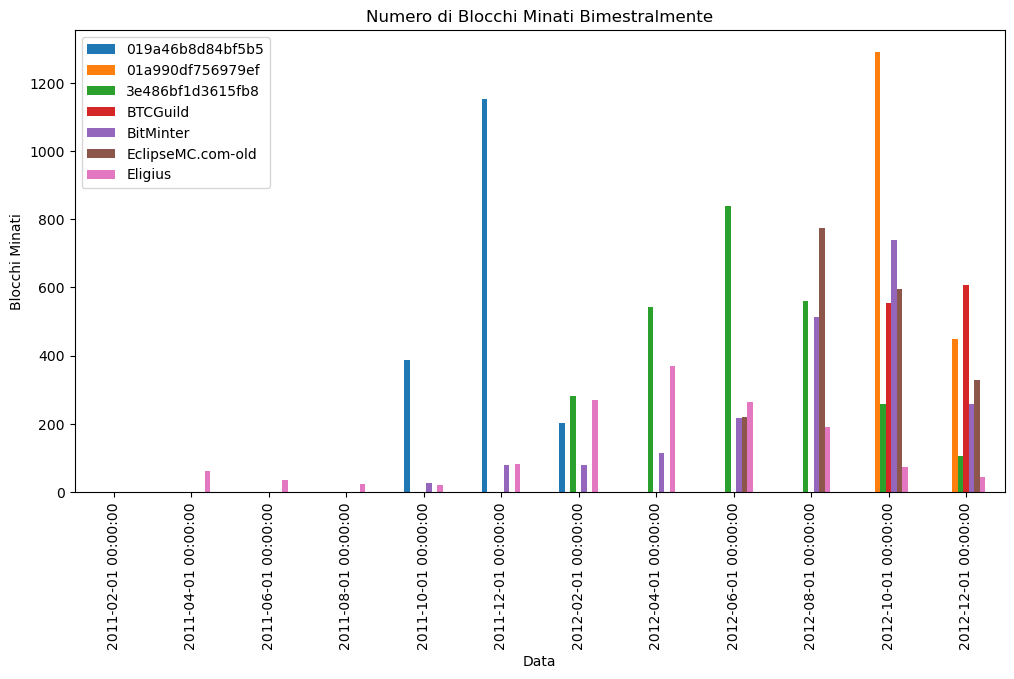

In [21]:
ax = framed.plot(kind="bar", stacked=False, figsize=(12, 6))
plt.title("Numero di Blocchi Minati Bimestralmente")
plt.xlabel("Data")
plt.ylabel("Blocchi Minati")

plt.legend()
plt.show()

# Analisi reward ricevute
## Svolgo prima l'analisi periodica

Inizio con quello periodico perché essenzialmente svolgo quello che ho fatto nella cella precedente, solo che questa volta i valori vengono presi nella colonna <code>amount</code> e non su <code>blockId</code> e invece di applicare <code>count</code> applico <code>sum</code>. Divido le reward con il cambio satoshi/btc, in modo da ottenere valori espressi in btc.

Anche questa volta creo due grafici a barre, stacked e non.

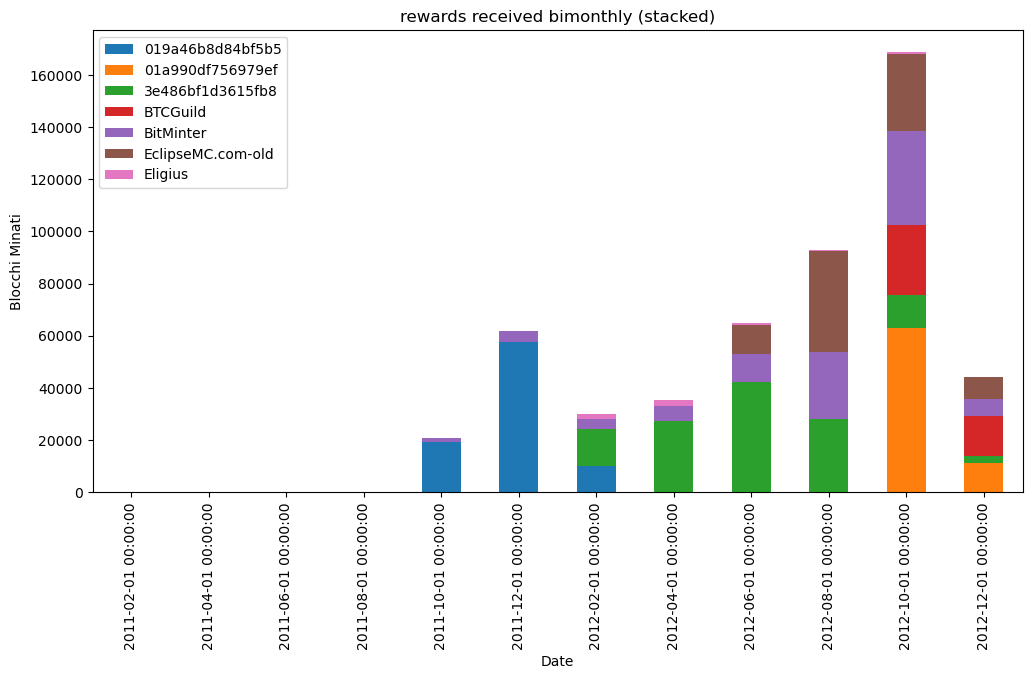

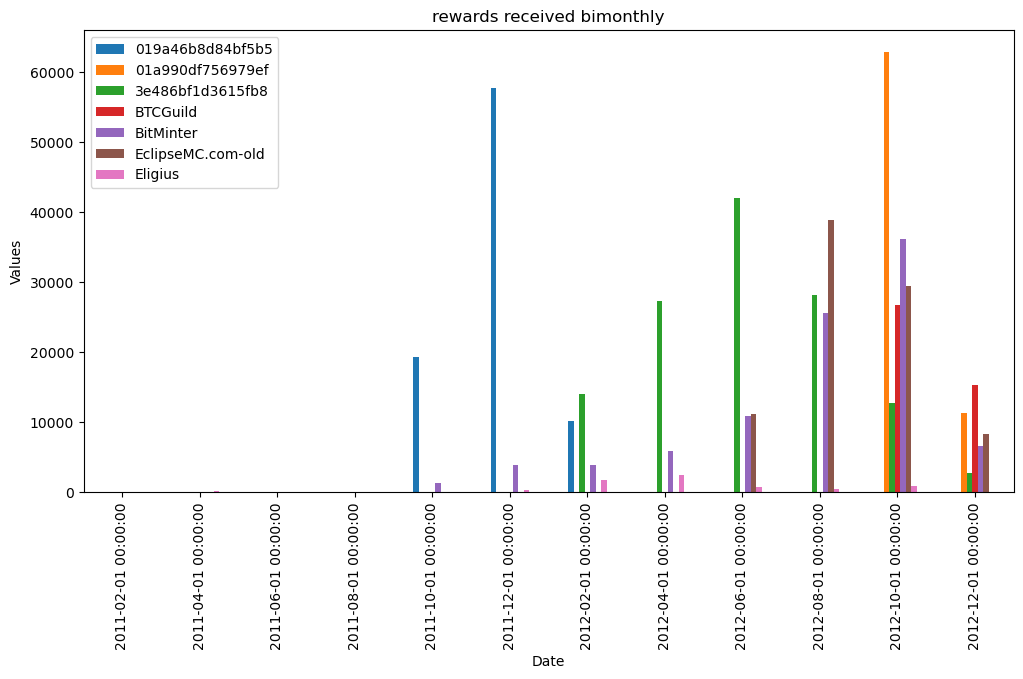

In [22]:
satoshi_value=100000000
framed = only_coinbase[only_coinbase["pool"]!="Others"].pivot_table(index=pd.Grouper(key="timestamp", freq="2MS"), columns="pool", values="amount", aggfunc="sum", fill_value=0)
framed = framed/satoshi_value

ax = framed.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("rewards received bimonthly (stacked)")
plt.xlabel("Date")
plt.ylabel("Blocchi Minati")

plt.legend()
plt.show()
ax = framed.plot(kind="bar", stacked=False, figsize=(12, 6))
plt.title("rewards received bimonthly")
plt.xlabel("Date")
plt.ylabel("Values")

plt.legend()
plt.show()

## Analisi reward globalmente
In questo caso ho già il dataframe pronto, per questo motivo ho deciso di fare l'analisi globale solo dopo quella temporale. Prendo il dataset usato al passo precedente e applico la funzione di aggregazione <code>sum</code> per sommare i btc ricevuti come reward per ogni pool/miner. 

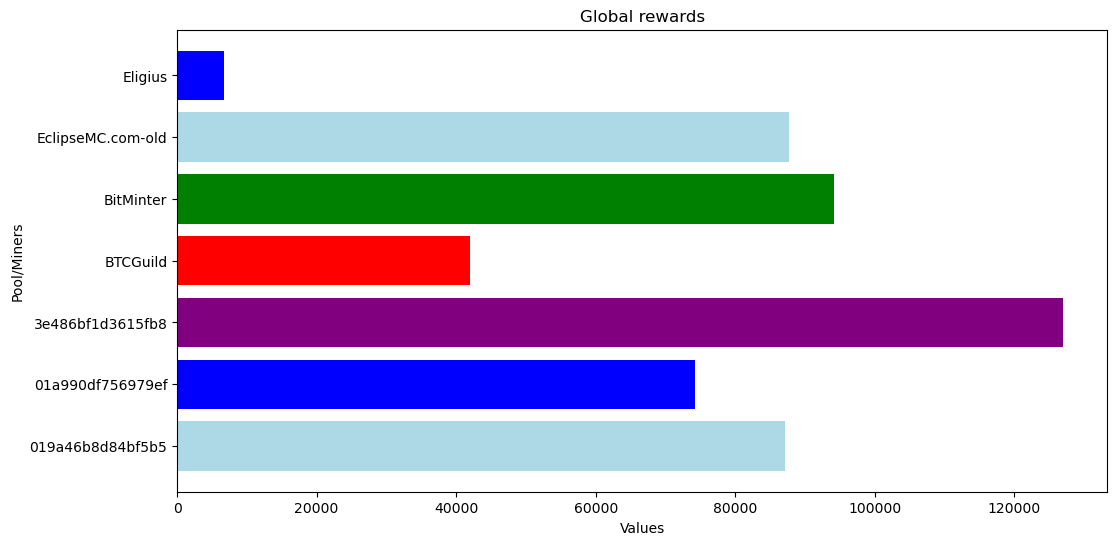

In [23]:
plt.figure(figsize=(12, 6))
res = framed.agg("sum")
plt.barh(res.index,res.values,color = color)
plt.title("Global rewards")
plt.xlabel("Values")
plt.ylabel("Pool/Miners")
plt.show()

## Distribuzione delle reward per ogni miner/pool
Faccio una group by sul dataframe <code>only_coinbase</code> sulla colonna <code>pool</code>, successivamente itero sul DataFrameGroupBy e ad ogni iterazione genero un sublot con il pool/miner corrente.
Sull'asse x sono presenti i valori espressi in bitcoin (ho diviso le series per <code>satoshi_value</code>, sull'asse y invece la frequenza associata.

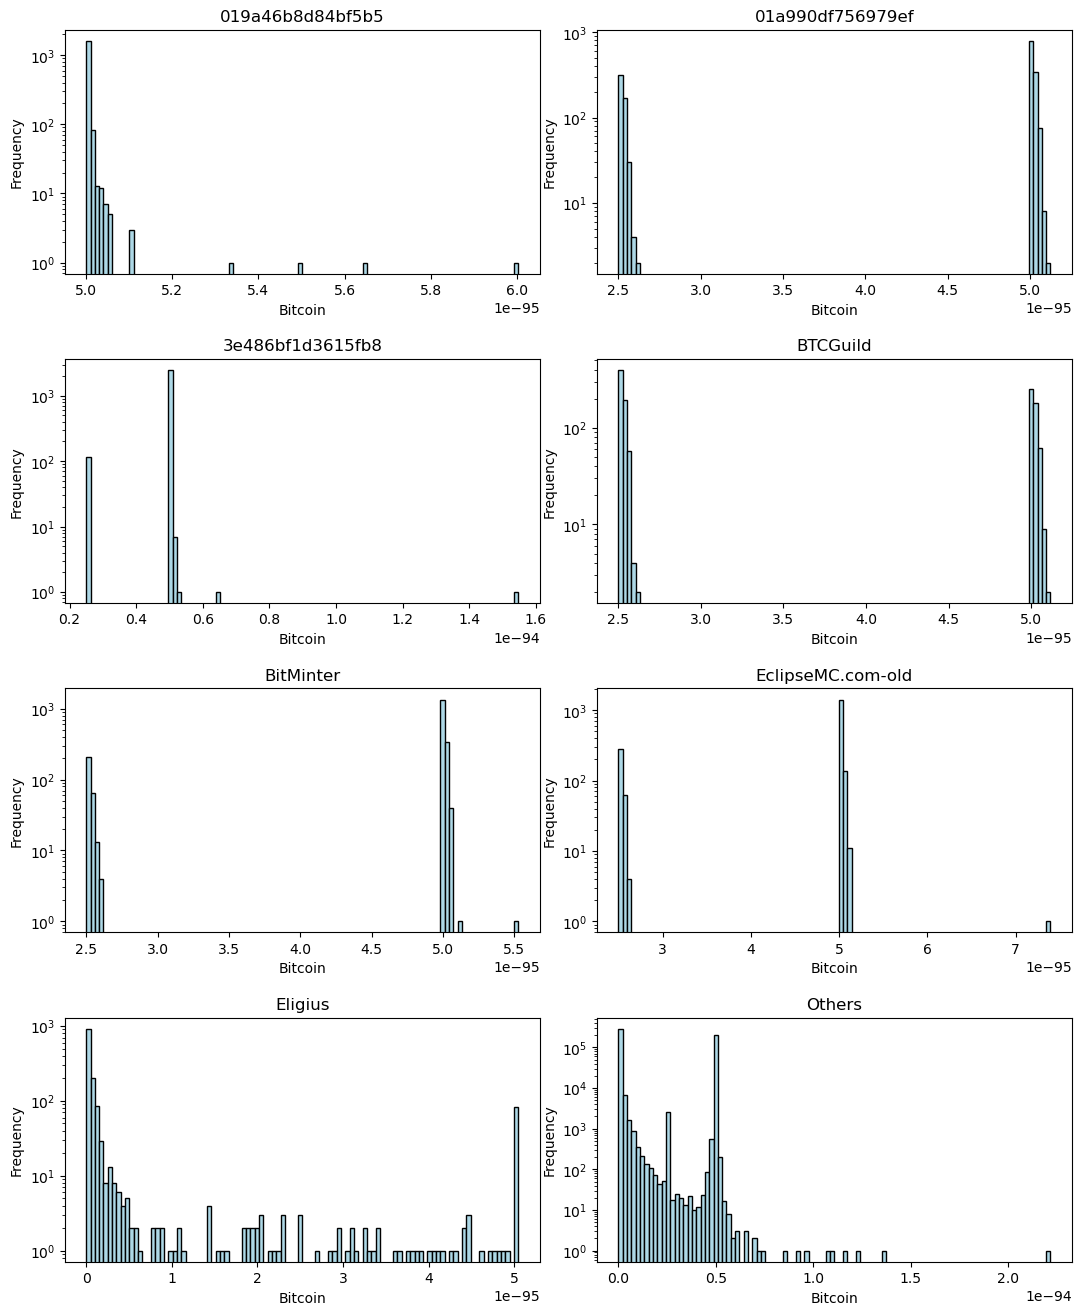

In [49]:
only_coinbase["amount"] = only_coinbase["amount"] / satoshi_value
grouped = only_coinbase[["pool","amount"]].groupby("pool")
fig, axs = plt.subplots(4, 2, figsize=(13, 16))
plt.subplots_adjust(wspace=0.12, hspace=0.35)
row=0
column= 0
for key, value in grouped:
    axs[row, column].hist(value["amount"], color = 'lightblue', edgecolor = 'black',bins = int(100), label=key)
    axs[row, column].set_yscale("log")
    axs[row, column].set_xlabel("Bitcoin")
    axs[row, column].set_ylabel("Frequency")
    axs[row, column].set_title(key)
    column +=1
    if column == 2:
        column = 0
        row +=1
plt.show()
# Alternativa, però meno chiara a parer mio
# grouped[["amount"]].plot(kind="hist", bins = 100, logy = True, subplots = True)

# Ricostruzione flusso di bitcoin a partire da una transizione
Definisco un metodo <code>get_next_output</code> che si occupa di restituirmi tutti gli output data una transizione. Il risultato è una lista di quadruple, della forma: (url_padre, indirizzo, url_transazione, livello). 
Questa lista mi permette di costruire il grafo associato usando <code>networkx</code> con molta facilità, perché ogni entry ha tutte le informazioni necessarie per generare un arco con gli altri eventuali nodi ma anche per sapere quale url devo esplorare o per sapere quando siamo arrivati al livello limite. La profondità massima è definita da <code>limit_k</code>.

In [223]:
def get_next_output(url, parent_label, level):
    response = request_with_proxy(url)
    b_soup=BeautifulSoup(response.text,"html.parser")
    rows=b_soup.find_all("table",{"class":"empty"})[1]
    if rows == None: #it means we have done too many requests
        return []
    txId_list = rows.find_all("td", {"class":"small"})
    address_list = rows.find_all("span", {"class":"outnumber"})
    td_list = zip(txId_list, address_list)
    return [(
        parent_label, 
        address.find_next_sibling()["href"].replace("/address/","") if address.find_next_sibling().has_attr("href") else None, 
        txId.find("a",{"href": re.compile(r"^/txid")})["href"] if txId.find("a",{"href": re.compile(r"^/txid")},) != None else "None",  
        level +1
        ) 
            for txId,address in td_list
        ]

Genero nuovamente le proxies in quanto all'aumentare della profondita, aumenteranno anche il numero di richieste svolte a WalletExplorer, in questo modo ci assicuriamo di non essere a corto di proxies.

Svolgo un ciclo while finché non viene raggiunta la profondita massima o la lista di <code>next_outputs</code> non è vuota (ovvero non ci sono più nodi da esplorare). <code>next_outputs</code> rappresenta una coda in cui inserisco i nodi ancora da elaborare.

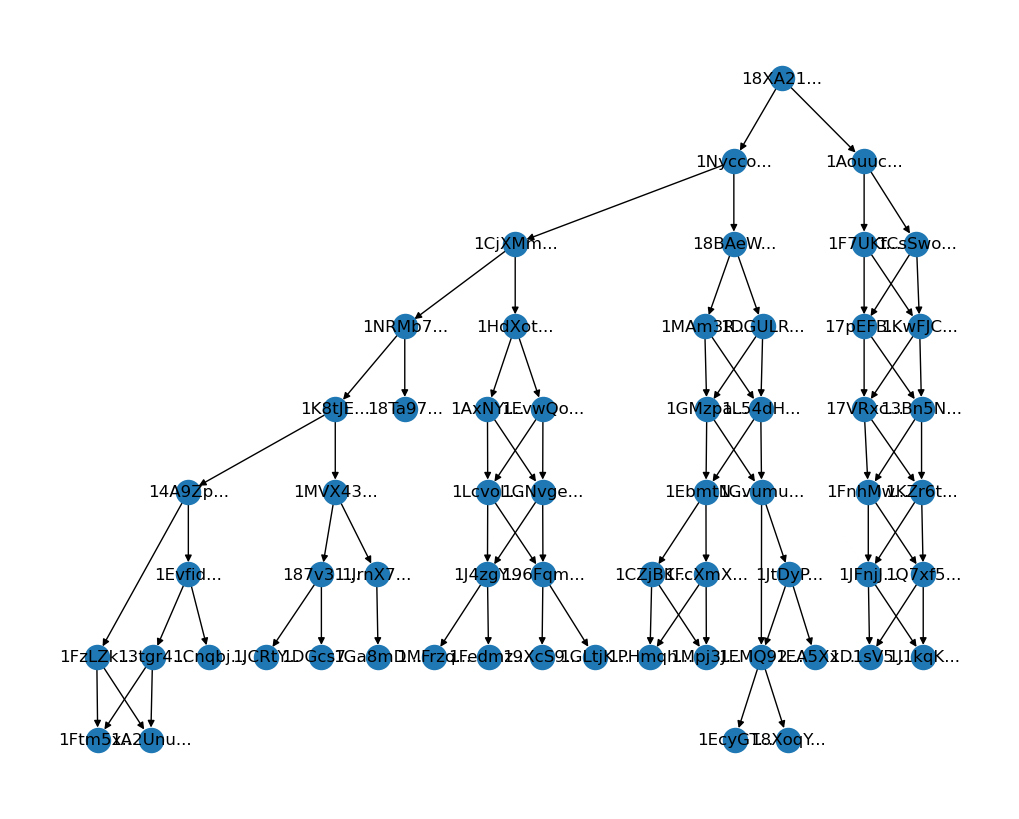

In [231]:
limit_k = 9
generate_proxies()
label = "18XA21sczeZkqrYYuQoN9KHQEQe2G2haJg"
transaction = "txid/c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"

G = nx.DiGraph()

level = 0
unspent_count = 0
next_outputs = get_next_output(base_url+transaction,"Root",0)
next_outputs[0] = ("txid/c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6", next_outputs[0][1], next_outputs[0][2], next_outputs[0][3])
while len(next_outputs) != 0:
    current_node = next_outputs.pop(0)
    if current_node[3] == limit_k:
        break
    if current_node[1] == None:
        continue
    if not G.has_node(current_node[1]):
        G.add_node(current_node[1], data=(current_node[1], current_node[2]))
    for key, value in G.nodes.data():
        if current_node[0] in value["data"][1] and current_node[1] != key:
            G.add_edge(key,current_node[1])
    if current_node[2] != "None":
        res = get_next_output(base_url+current_node[2],current_node[2],current_node[3])
        next_outputs = next_outputs + res
plt.figure(figsize=(10, 8))
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G,pos, labels = {x[0]:x[1]["data"][0][0:6]+"..." for x in G.nodes.data() if x[1]["data"] != None}, with_labels = True)
plt.show()

Di seguito una versione lerggemente allargata per visualizzare meglio i label. 
Si possono in questa maniera verificare facilmente i percorsi su WalletExplorer partendo dal nodo radice.

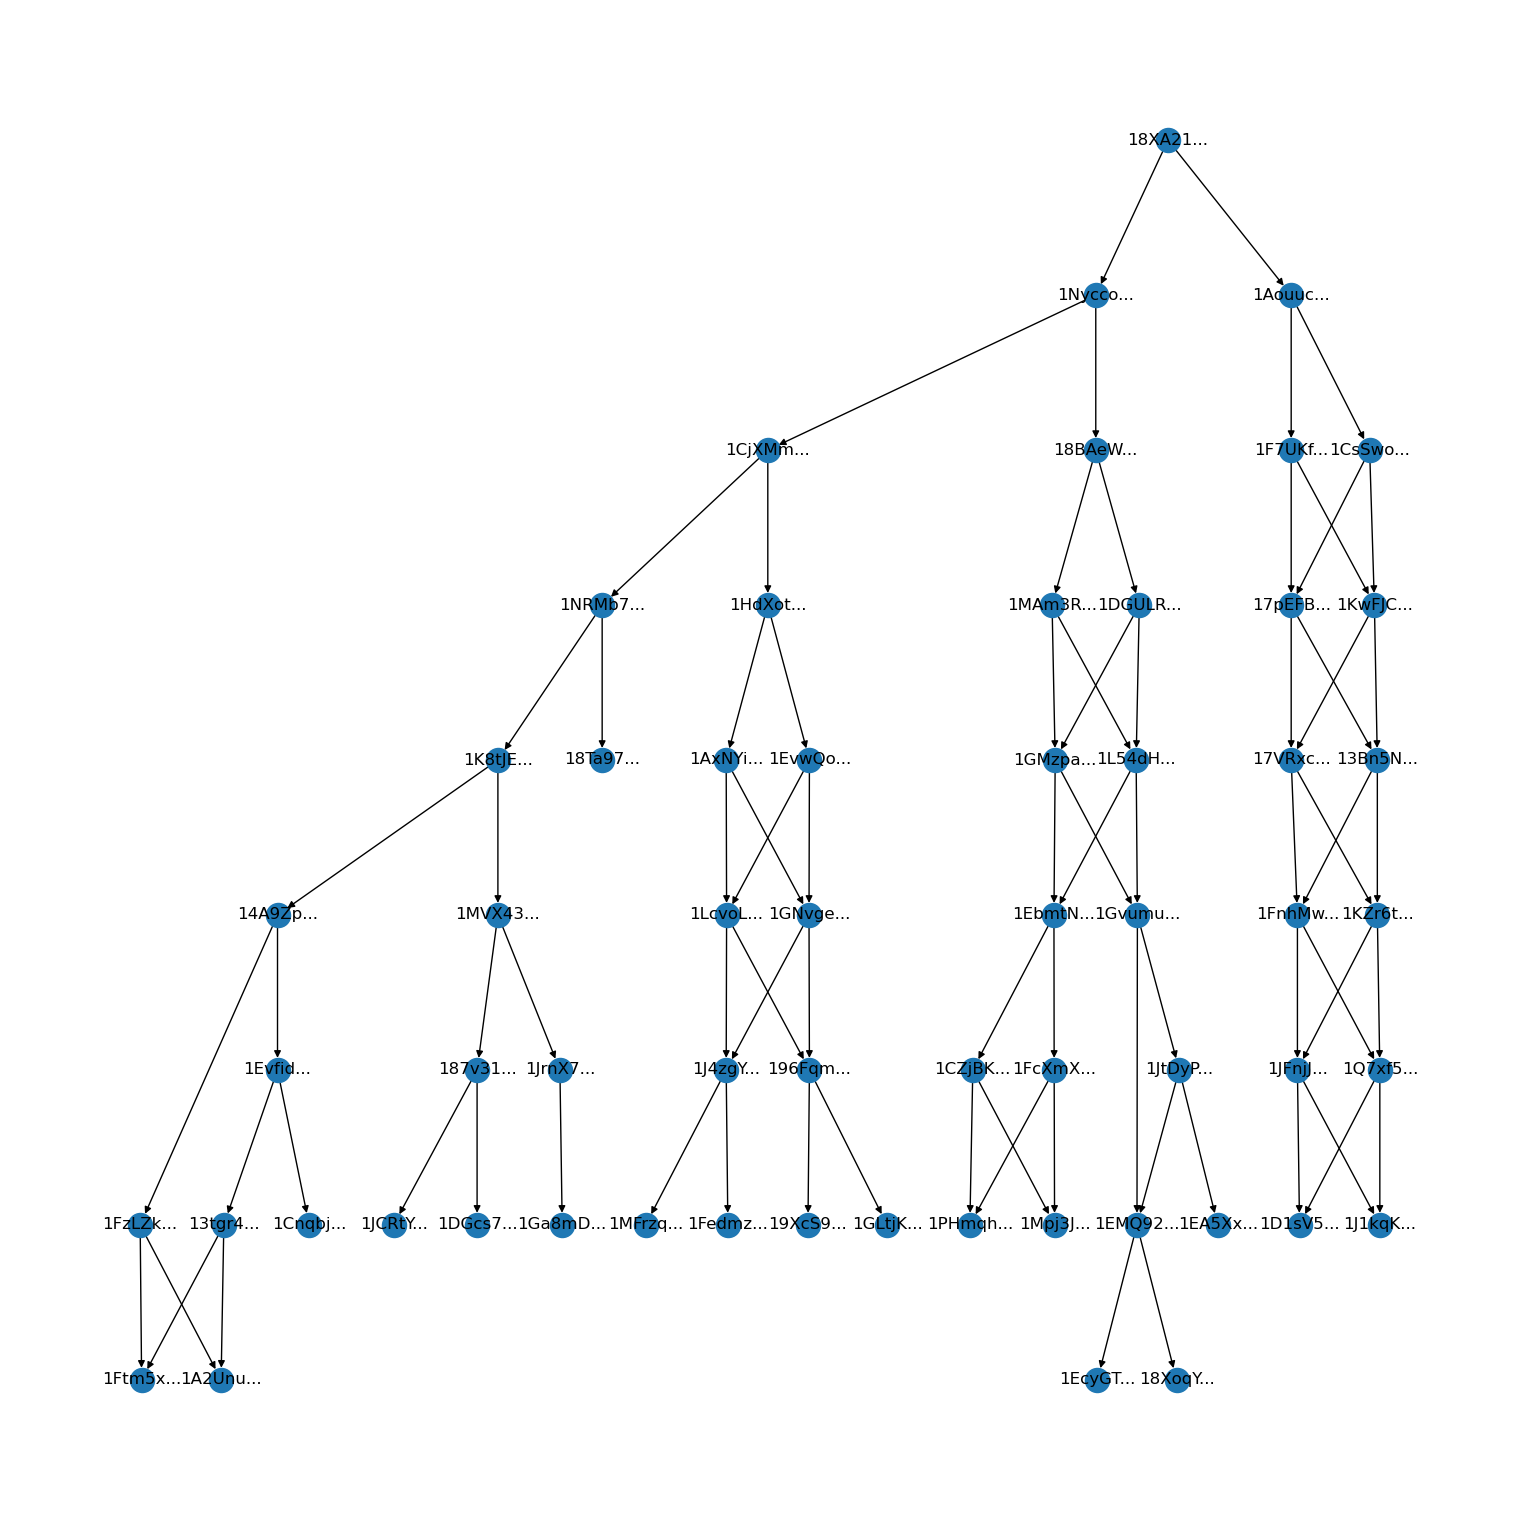

In [243]:
plt.figure(figsize=(15, 15))
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G,pos, labels = {x[0]:x[1]["data"][0][0:6]+"..." for x in G.nodes.data() if x[1]["data"] != None}, with_labels = True)
plt.show()